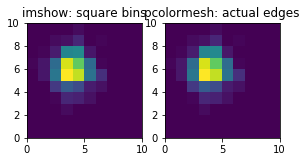

In [62]:
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt
import numpy as np
import json

xedges = [0, 1, 3, 5]
yedges = [0, 2, 3, 4, 6]

xedges = np.linspace(0, 10, 11)
yedges = np.linspace(0, 10, 11)

x = np.random.normal(4, 1, 512)
y = np.random.normal(6, 1, 512)
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))

# Histogram does not follow Cartesian convention (see Notes),
# therefore transpose H for visualization purposes.
H = H.T

fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(131, title='imshow: square bins')
plt.imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

ax = fig.add_subplot(132, title='pcolormesh: actual edges',
        aspect='equal')
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, H)

# ax = fig.add_subplot(133, title='NonUniformImage: interpolated',
#         aspect='equal', xlim=xedges[[0, -1]], ylim=yedges[[0, -1]])
# im = NonUniformImage(ax, interpolation='bilinear')
# xcenters = (xedges[:-1] + xedges[1:]) / 2
# ycenters = (yedges[:-1] + yedges[1:]) / 2
# im.set_data(xcenters, ycenters, H)
# ax.images.append(im)
# plt.show()


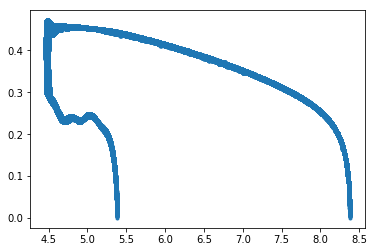

In [546]:
# fn = '/Users/weugene/basilisk/work/tube/res21/r_over_x_total_t=9.98087.csv'
fn = '/Users/weugene/basilisk/work/tube/res25/r_over_x_t=2.24991.csv'
# fn = '/Users/weugene/basilisk/work/tube/res22/r_over_x_t=0.478693.csv'

with open(fn, 'r') as f:
    lists = json.load(f)
    x, y = np.array(lists[0]), np.array(lists[1])
plt.plot(x,y, '.')

5.380413055419922 1.848538543153476e-15 8.37833309173584 1.848538543153476e-15


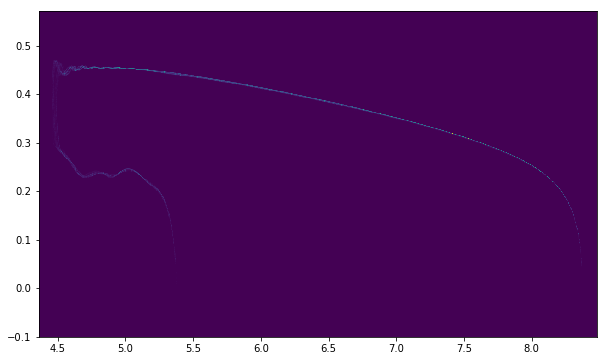

In [547]:
N = 1024
xmin = x.min() - 0.1
xmax = x.max() + 0.1
xcm=0.5*(xmin+xmax)
ymin = y.min() - 0.1
ymax = y.max() + 0.1
arg = y[x<xcm].argmin()
x0, y0 = x[x<xcm][arg], y[x<xcm][arg]
arg = y[x>xcm].argmin()
xN, yN = x[x>xcm][arg], y[x>xcm][arg]
print(x0, y0, xN, yN)
xedges = xmin + (xmax - xmin)*np.linspace(0,1,N)
yedges = ymin + (ymax - ymin)*np.linspace(0,1,N)
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))

# Histogram does not follow Cartesian convention (see Notes),
# therefore transpose H for visualization purposes.
H = H.T *(255.0/H.max())

fig = plt.figure(figsize=(10, 6))
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, H)

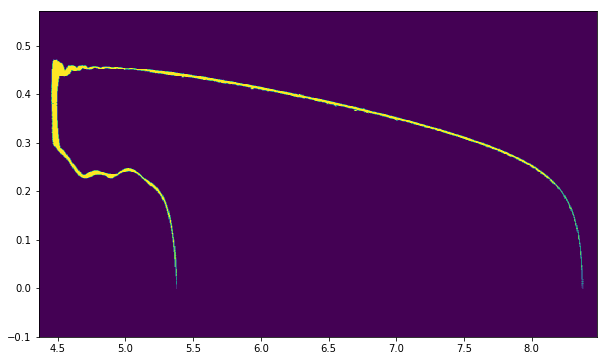

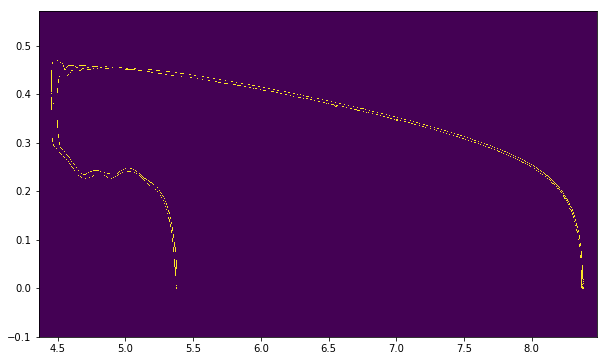

In [548]:
import cv2 as cv
from matplotlib import pyplot as plt
kernel = np.ones((3,3),np.float32)/9
# dst = cv.filter2D(H,-1,kernel)
H_step = H.copy()
H_step = np.where(H_step>0, 255, 0)
dst = H_step.copy().astype(np.uint8)
for i in range(1):
    dst = cv.GaussianBlur(dst,(3,3),0, 0)
# dst = cv.bilateralFilter(H,5,75,75)

fig = plt.figure(figsize=(10, 6))
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, dst)

edges = cv.Canny(image=dst, threshold1=10, threshold2=10)
fig = plt.figure(figsize=(10, 6))
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, edges)

In [549]:
coords = []
for i in range(len(xedges)-1):
    for j in range(len(yedges)-1):
        if H[i,j]>0:
            coords.append((X[i,j], Y[i,j]))

In [550]:
from scipy.spatial import Delaunay
from scipy.signal import find_peaks

def find_edges_with(i, edge_set):
	i_first = [j for (x,j) in edge_set if x==i]
	i_second = [j for (j,x) in edge_set if x==i]
	return i_first,i_second

def stitch_boundaries(edges):
	edge_set = edges.copy()
	boundary_lst = []
	while len(edge_set) > 0:
		boundary = []
		edge0 = edge_set.pop()
		boundary.append(edge0)
		last_edge = edge0
		while len(edge_set) > 0:
			i,j = last_edge
			j_first, j_second = find_edges_with(j, edge_set)
			if j_first:
				edge_set.remove((j, j_first[0]))
				edge_with_j = (j, j_first[0])
				boundary.append(edge_with_j)
				last_edge = edge_with_j
			elif j_second:
				edge_set.remove((j_second[0], j))
				edge_with_j = (j, j_second[0])  # flip edge rep
				boundary.append(edge_with_j)
				last_edge = edge_with_j

			if edge0[0] == last_edge[1]:
				break

		boundary_lst.append(boundary)
	return boundary_lst[0]

def alpha_shape(points, alpha, only_outer=True):
	"""
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
	assert points.shape[0] > 3, "Need at least four points"

	def add_edge(edges, i, j):
		"""
        Add an edge between the i-th and j-th points,
        if not in the list already
        """
		if (i, j) in edges or (j, i) in edges:
			# already added
			assert (j, i) in edges, "Can't go twice over same directed edge right?"
			if only_outer:
				# if both neighboring triangles are in shape, it's not a boundary edge
				edges.remove((j, i))
			return
		edges.add((i, j))

	tri = Delaunay(points)
	edges = set()
	# Loop over triangles:
	# ia, ib, ic = indices of corner points of the triangle
	for ia, ib, ic in tri.vertices:
		pa = points[ia]
		pb = points[ib]
		pc = points[ic]
		# Computing radius of triangle circumcircle
		# www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
		a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
		b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
		c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
		s = (a + b + c) / 2.0
		area = np.sqrt(s * (s - a) * (s - b) * (s - c))
		circum_r = a * b * c / (4.0 * (area + 1e-16)) #corrected by Weugene
		if circum_r < alpha:
			add_edge(edges, ia, ib)
			add_edge(edges, ib, ic)
			add_edge(edges, ic, ia)
	return edges


def find_min_max_curve(points, p0, pN, alpha=0.05):
	# Computing the alpha shape
	edges = alpha_shape(points, alpha=alpha, only_outer=True)
	plt.figure(figsize=(15,6))
	for e in edges:
		plt.plot([points[e[0]][0], points[e[1]][0]], [points[e[0]][1], points[e[1]][1]],'b-')
	plt.axis('equal')
	plt.axis('scaled')
	plt.show()
	#order edges
	edges = stitch_boundaries(edges)

	edge_points = np.zeros((len(edges),2))
	k=0
	for i, j in edges:
		edge_points[k,:] = points[[i, j], 0][0] , points[[i, j], 1][0]
		k += 1
	inodes, jnodes = zip(*edges)
	min_x_ind = np.argmin(np.linalg.norm(edge_points - p0,axis=1))
	max_x_ind = np.argmin(np.linalg.norm(edge_points - pN,axis=1))
	print("min_x_ind={} max_x_ind={}".format(min_x_ind, max_x_ind))
	#     min_x_ind = np.argmin(edge_points[:, 0])
	#     max_x_ind = np.argmax(edge_points[:, 0])
	if min_x_ind < max_x_ind:
		lower_hull = edge_points[min_x_ind:max_x_ind+1, :]
		upper_hull = np.concatenate([edge_points[max_x_ind:, :], edge_points[:min_x_ind+1, :]])
	else:
		upper_hull = edge_points[max_x_ind:min_x_ind+1, :]
		lower_hull = np.concatenate([edge_points[min_x_ind:, :], edge_points[:max_x_ind+1, :]])
	return lower_hull, upper_hull

from scipy import interpolate
def find_first_peak(x_fil, y_fil, x0, xmin, xmax, x_mean, time):
	if x_fil[0] > x_fil[-1]:
		x_fil = x_fil[::-1]
		y_fil = y_fil[::-1]
	ind = np.argmax(y_fil)
	print("max ={} {}".format(x_fil[ind], y_fil[ind]))
	#choose some points if they are:
	args = (y_fil >= 0.3) & (x_fil <= x_mean)
	x_ripple = x_fil[args]
	y_ripple = y_fil[args]

	print("sizes of ripple:{} {}".format(x_ripple.shape, y_ripple.shape))
	#return 0, 0, 0, 0, 0, 0, 0
	#find the first peak in a smoothed curve
	peaks, props = find_peaks(y_ripple, prominence=0.0001)
	print("peaks, props:", peaks, props)
	try:
		x_peak, y_peak = x_ripple[peaks[0]], y_ripple[peaks[0]]
	except:
		x_peak, y_peak = np.inf, np.inf
	length_x_peak_mean = x_mean - x_peak
	print('x_peak candidates=', x_ripple[peaks], 'y_peak candidates=', y_ripple[peaks])
	print('x_peak', x_peak, 'y_peak=', y_peak, "length_x_peak_mean=", length_x_peak_mean)

	return x_peak, y_peak, length_x_peak_mean

/Users/weugene/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in sqrt


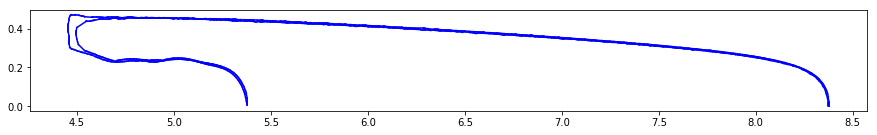

min_x_ind=669 max_x_ind=1487
max =4.472006269960227 0.4716537208708342
sizes of ripple:(429,) (429,)
peaks, props: [ 91 106 121 134 148 163 185] {'prominences': array([0.07950586, 0.00131415, 0.00262829, 0.00197122, 0.00197122,
       0.00065707, 0.00065707]), 'left_bases': array([  0, 101, 114, 127, 142, 159, 181]), 'right_bases': array([426, 426, 426, 426, 426, 426, 426])}
x_peak candidates= [4.48811384 4.60086679 4.68543151 4.77402312 4.85858784 4.93509878
 5.04382485] y_peak candidates= [0.47165372 0.4598264  0.4598264  0.45785518 0.45785518 0.45654104
 0.45456982]
x_peak 4.488113835503512 y_peak= 0.4716537208708342 length_x_peak_mean= 1.9308944195013709


In [551]:
lower_hull, upper_hull = find_min_max_curve(np.asarray(coords), p0=[x0,y0], pN=[xN,yN], alpha=0.05)
x_peak, y_peak, length_x_peak_mean = find_first_peak(upper_hull[:,0], upper_hull[:,1], x0, xmin, xmax, xcm, 0)

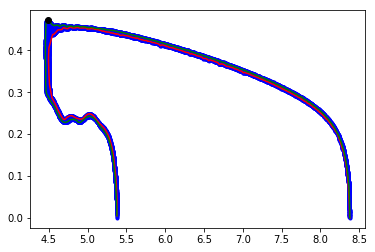

In [552]:
xx,yy = zip(*coords)
plt.plot(xx, yy, '.b')
plt.plot(lower_hull[:,0], lower_hull[:,1], 'r-')
plt.plot(upper_hull[:,0], upper_hull[:,1], 'g-')
plt.plot(x_peak, y_peak, 'k.', markersize=12)

In [553]:
[x0,y0], [xN,yN], x_peak, y_peak, length_x_peak_mean

([5.380413055419922, 1.848538543153476e-15],
 [8.37833309173584, 1.848538543153476e-15],
 4.488113835503512,
 0.4716537208708342,
 1.9308944195013709)

In [358]:
def distance(P1, P2):
    """
    This function computes the distance between 2 points defined by
     P1 = (x1,y1) and P2 = (x2,y2) 
    """
    dist = ((P1[0] - P2[0])**2 + (P1[1] - P2[1])**2) ** 0.5
    if dist > 0.5:
        return 1e+10
    return dist


def optimized_path(coords, start=None):
    """
    This function finds the nearest point to a point
    coords should be a list in this format coords = [ [x1, y1], [x2, y2] , ...] 

    """
    if start is None:
        start = coords[0]
    pass_by = []
    pass_by[:] = coords[:]
    path = [start]
    try:
        pass_by.remove(start)
    except:
        pass
    while pass_by:
        nearest = min(pass_by, key=lambda x: distance(path[-1], x))
        if distance(path[-1], nearest) < 0.1:
            path.append(nearest)
        pass_by.remove(nearest)
    return path

# define a start point
start = (x0, y0)
# coords = list(zip(x,y))
path = optimized_path(coords,start)

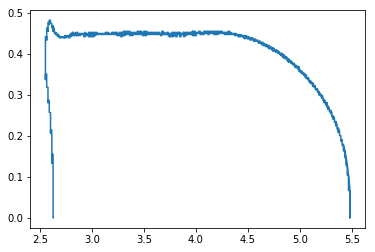

In [359]:
xx,yy = zip(*path)
plt.plot(xx,yy, '-')
# plt.plot(x,y, 'r.')